In [3]:
import networkx as nx
from shapely.geometry import Point,LineString,Polygon

import simpy
import xarray as xr

from opentnsim import core as core_module
from opentnsim import graph as graph_module
from opentnsim import lock_new as lock_module
from opentnsim import output as output_module
from opentnsim import vessel as vessel_module
from opentnsim import vessel_traffic_service as vessel_traffic_service_module
from opentnsim import zeesluisformulering as ZSF
from netCDF4 import Dataset
import datetime
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.dates as mdates
import folium
from shapely.ops import nearest_points, linemerge, split, snap, transform
import pyproj
import re
path = os.getcwd()

In [2]:
%load_ext autoreload
%autoreload 2

# Simulation parameters
## Time

In [3]:
output_path = path + '\\results\\Comparison\\'

In [4]:
t_sim = datetime.datetime(2023, 1, 1, 0, 0, 0)
t_start = datetime.datetime(2023, 2, 22, 0, 0, 0)
t_stop = datetime.datetime(2023, 3, 22, 0, 0, 0)

In [5]:
env = simpy.Environment(initial_time=t_start.timestamp())

env.epoch = t_start
env.simulation_start = t_start
env.simulation_stop = t_stop

## Network

In [6]:
network = pickle.load(open(path+"\\geofiles\\PortNetwork.pickle", "rb"))
env.FG = network

## Vessel traffic service
### Hydrodynamic data

In [7]:
hydrodynamic_data = xr.load_dataset(path+"\\hydrodynamic_data\\hydrodynamic_data_modified2.nc")

In [8]:
2.5*np.log(3/0.1)

np.float64(8.502993454155389)

### Vessel speed data

In [4]:
vessel_speed_data = pickle.load(open(path+'\\speed.pkl','rb'))

### Object

In [10]:
env.vessel_traffic_service = vessel_traffic_service_module.VesselTrafficService(FG=network, 
                                                                                hydrodynamic_start_time = hydrodynamic_data.TIME[0].values,
                                                                                hydrodynamic_information_path = path+"\\hydrodynamic_data\\hydrodynamic_data_modified2.nc", 
                                                                                vessel_speed_data_path = path + '\\speed.pkl')

## Vessels

In [11]:
#We create a type element that schematisizes a vessel
def create_vessel(env, 
                  name, 
                  origin, 
                  destination, 
                  vessel_type, 
                  bound,
                  L, 
                  B, 
                  T,
                  v,
                  actual_L,
                  actual_B,
                  arrival_time):
    Vessel = type('Vessel',(lock_module.PassesLockComplex,
                            vessel_module.IsVessel,
                           ),{})    

    vessel = Vessel(
        **{ "env": env,
            "name": name,
            "origin": origin,
            "destination": destination,
            "type": vessel_type,
            "bound": bound,
            "L": L,
            "B": B,
            "T": T,
            "v": v,
            "actual_L":actual_L,
            "actual_B":actual_B,
            "arrival_time": arrival_time
        }
    )

    vessel.process = env.process(vessel.move())
    
    return vessel

In [12]:
vessels_df = pickle.load(open(path + "\\vessels\\modelled_vessels.pickle",'rb'))

In [13]:
vessels_df = vessels_df.drop_duplicates('arrival_time')
vessels_df = vessels_df.reset_index(drop=True)

In [14]:
vessels_df = vessels_df.reset_index(drop=True)

In [15]:
vessels = []
for index,vessel in vessels_df.iterrows(): 
    ship = create_vessel(env=env, 
                         name=vessel['name'], 
                         origin = vessel['origin'],
                         destination = vessel['destination'],
                         vessel_type='sea-going cargo vessel',
                         L=100,
                         B=50, 
                         T=vessel['T'],
                         v=4,
                         bound = vessel['bound'],
                         actual_L = vessel['L'],
                         actual_B = vessel['B'],
                         arrival_time = vessel['arrival_time'])
    vessels.append(ship)
    # if vessel['arrival_time'] > pd.Timestamp('2023-02-25 12:00'):
    #     break

In [16]:
operational_hours = pd.DataFrame(columns=['start_time','stop_time'])
# block_time = pd.Timedelta(hours=12)
# operational_hours_start = np.arange(pd.Timestamp(t_start),pd.Timestamp(t_stop)+block_time*2,block_time*2)
# operational_hours_stop = np.arange(pd.Timestamp(t_start)+block_time,pd.Timestamp(t_stop)+block_time*2,block_time*2)
# for index,(start_time,stop_time) in enumerate(zip(operational_hours_start,operational_hours_stop)):
#     operational_hours.loc[index,:] = [start_time,stop_time]

In [17]:
# we add a lock to an edge in the network
lock_I = lock_module.IsLockComplex(env=env,
                                   name='Sea Lock IJmuiden',
                                   start_node='lock_sea', #start node of lock complex (one edge)
                                   node_open='lock_sea', #node where doors are open at t=0  --->>> channel side, cause first vessel outbound
                                   end_node='lock_lake', #stop node of lock complex (one edge)
                                   approach_node_A = '5mile',
                                   approach_node_B = 'Houtrak',
                                   max_additional_delay = 0.0*60*60,
                                   clustering_time = 36*60*60,
                                   distance_lock_doors_A_to_lineup_area_A=4800,
                                   distance_lock_doors_B_to_lineup_area_B=4800,
                                   distance_lock_doors_A_to_waiting_area_A=5000,
                                   distance_lock_doors_B_to_waiting_area_B=5000,
                                   distance_from_start_node_to_lock_doors_A = 1900.4821523031071,
                                   distance_from_end_node_to_lock_doors_B = 574.1330419091661,
                                   lock_length = 545,
                                   lock_width = 70,
                                   lock_depth = 17.75,
                                   disch_coeff = 0.65,
                                   gate_opening_time = 120,
                                   opening_area = 14*3*2.2,
                                   lineup_area_A_length=0,
                                   lineup_area_B_length=0,
                                   effective_lineup_area_A_length=545,
                                   effective_lineup_area_B_length=545,
                                   sailing_distance_to_crossing_point = 1000,
                                   #levelling_time=1500,
                                   doors_opening_time=4.5*60,
                                   doors_closing_time=4.5*60,
                                   speed_reduction_factor_lineup_area_A=0.75,
                                   speed_reduction_factor_lineup_area_B=0.75,
                                   speed_reduction_factor_lock_chamber=0.75,
                                   sailing_in_time_gap = 5*60,
                                   sailing_out_time_gap = 1.5*60.,
                                   time_step = 5,
                                   min_vessels_in_operation = 0,
                                   max_vessels_in_operation = 4,
                                   minimize_door_open_times = False,
                                   closing_doors_in_between_operations = True,
                                   close_doors_before_vessel_is_laying_still = True,
                                   sailing_time_before_opening_lock_doors = 10*60,
                                   sailing_time_before_closing_lock_doors = 1*60.,
                                   detector_nodes = ['5mile','Houtrak'],
                                   operational_hours = operational_hours,
                                   predictive=True)

# Run 

In [18]:
for vessel in vessels:
    print(vessel.id,vessel.bound,vessel.metadata['arrival_time'])

9c96b283-0c7f-4705-8229-fa23eeb5dbc4 inbound 2023-02-23 02:32:40.891420
092a7ded-5ce7-4bf4-9e52-deac86431966 inbound 2023-02-23 02:49:57
505e06bd-76ff-4fee-a144-9dddbbdf1a18 outbound 2023-02-23 04:03:51
26a86e27-1b68-48b4-af15-9dc78171c5f1 outbound 2023-02-23 04:38:18.664463
3e603346-fbdb-4396-937f-418c71b30681 inbound 2023-02-23 05:40:54
cddccbf3-a3db-4837-8a64-38e27738de6c outbound 2023-02-23 07:20:34.664463
5afd19b1-3971-4490-88b1-8d09dfa1282c inbound 2023-02-23 08:48:15
7a25a162-f929-402e-9c93-6c5996c8deb6 outbound 2023-02-23 12:23:12
28e8b548-fefc-40cb-a188-e1747098447e inbound 2023-02-23 13:26:12.891420
d1d4f71c-265a-45db-a031-b782384782be inbound 2023-02-23 16:57:28
f840a41f-0d65-48c1-921f-493b282c3fee inbound 2023-02-23 23:53:43
5ab0be92-5f3c-487b-8bef-6bb549a2fc34 outbound 2023-02-24 02:21:43
0823b86b-90e5-46ca-bb9f-bfef9341620c outbound 2023-02-24 03:13:12.664463
21ae1b8d-a323-4f70-b6fc-3fad153bd818 outbound 2023-02-24 05:52:46
f2b0b55b-1e84-49e0-acce-5b9e76ee874e outbound 20

In [19]:
env.run()

In [20]:
lock_I.operation_pre_planning

,bound,vessels,capacity_L,capacity_B,time_potential_lock_door_opening_stop,time_operation_start,time_entry_start,time_entry_stop,time_door_closing_start,time_door_closing_stop,...,time_door_opening_stop,time_departure_start,time_departure_stop,time_operation_stop,time_potential_lock_door_closure_start,wlev_A,wlev_B,maximum_individual_delay,total_delay,status
lock_operation,,,,,,,,,,,,,,,,,,,,,
0,0,[<__main__.Vessel object at 0x0000024F3B3C53C0...,145,-130,2023-02-23 09:19:49.073664842,2023-02-23 09:22:31.708276189,2023-02-23 09:30:37.669819136,2023-02-23 09:47:12.432320010,2023-02-23 09:47:26.265973430,2023-02-23 09:51:56.265973430,...,2023-02-23 09:59:06.265973430,2023-02-23 10:00:50.002512295,2023-02-23 10:05:51.298668921,2023-02-23 10:13:57.260211868,2023-02-23 10:07:39.894823215,-0.07,-0.4,0 days 12:17:53.217160,1 days 06:12:41.217160,not available
1,1,[<__main__.Vessel object at 0x0000024F3B3C7AC0...,145,-130,2023-02-23 12:48:15.745971959,2023-02-23 12:50:58.380583306,2023-02-23 12:59:04.342126253,2023-02-23 13:15:39.104627127,2023-02-23 13:15:52.938280547,2023-02-23 13:20:22.938280547,...,2023-02-23 13:27:37.938280547,2023-02-23 13:29:21.674819412,2023-02-23 13:34:22.970976038,2023-02-23 13:42:28.932518985,2023-02-23 13:36:11.567130332,-0.743,-0.4,0 days 12:15:46.363916648,1 days 07:08:40.585593040,not available
2,0,[<__main__.Vessel object at 0x0000024F3B3C7EE0...,145,-130,2023-02-24 07:17:32.073664842,2023-02-24 07:20:14.708276189,2023-02-24 07:28:20.669819136,2023-02-24 07:44:55.432320010,2023-02-24 07:45:09.265973430,2023-02-24 07:49:39.265973430,...,2023-02-24 07:59:19.265973430,2023-02-24 08:01:03.002512295,2023-02-24 08:06:04.298668921,2023-02-24 08:14:10.260211868,2023-02-24 08:07:52.894823215,0.81,-0.4,1 days 10:27:05.217160,3 days 03:37:50.217160,ready
3,1,[<__main__.Vessel object at 0x0000024F3B440C70...,145,-130,2023-02-24 08:07:52.894823215,2023-02-24 08:10:35.529434562,2023-02-24 08:18:41.490977509,2023-02-24 08:35:16.253478383,2023-02-24 08:35:30.087131803,2023-02-24 08:40:00.087131803,...,2023-02-24 08:49:00.087131803,2023-02-24 08:50:43.823670668,2023-02-24 08:55:45.119827294,2023-02-24 09:03:51.081370241,2023-02-24 08:57:33.715981588,0.838,-0.4,0 days 09:30:30.813314256,0 days 20:56:03.595405024,not available
4,0,[<__main__.Vessel object at 0x0000024F3B4422F0...,145,-130,2023-02-24 18:23:02.965084842,2023-02-24 18:25:45.599696189,2023-02-24 18:33:51.561239136,2023-02-24 18:50:26.323740010,2023-02-24 18:50:40.157393430,2023-02-24 18:55:10.157393430,...,2023-02-24 19:06:25.157393430,2023-02-24 19:08:08.893932295,2023-02-24 19:13:10.190088921,2023-02-24 19:21:16.151631868,2023-02-24 19:14:58.786243215,1.635,-0.4,0 days 19:01:44.036651896,1 days 22:45:27.819491896,ready
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1,[<__main__.Vessel object at 0x0000024F3BAC31F0...,145,-130,2023-03-08 14:17:43.410434959,2023-03-08 14:20:26.045046306,2023-03-08 14:28:32.006589253,2023-03-08 14:45:06.769090127,2023-03-08 14:45:20.602743547,2023-03-08 14:49:50.602743547,...,2023-03-08 14:56:45.602743547,2023-03-08 14:58:29.339282412,2023-03-08 15:03:30.635439038,2023-03-08 15:11:36.596981985,2023-03-08 15:05:19.231593332,-0.144,-0.4,0 days 04:27:54.242973205,0 days 09:42:01.603122693,ready
76,0,[],545,70,2023-03-08 16:06:35.745971959,2023-03-08 16:06:35.745971959,2023-03-08 16:06:35.745971959,2023-03-08 16:06:35.745971959,2023-03-08 16:06:35.745971959,2023-03-08 16:11:05.745971959,...,2023-03-08 16:11:05.745971959,2023-03-08 16:11:05.745971959,2023-03-08 16:11:05.745971959,2023-03-08 16:11:05.745971959,2023-03-08 16:11:05.745971959,1.005,-0.4,0 days 00:00:00,0 days 00:00:00,not available
77,1,[<__main__.Vessel object at 0x0000024F3BAED690...,145,-130,2023-03-08 19:32:03.410434959,2023-03-08 19:34:46.045046306,2023-03-08 19:42:52.006589253,2023-03-08 19:59:26.769090127,2023-03-08 19:59:40.602743547,2023-03-08 20:04:10.602743547,...,2023-03-08 20:12:15.602743547,2023-03-08 20:13:59.3

In [21]:
lock_I.vessel_pre_planning[lock_I.vessel_pre_planning.operation_index == 16]

,bound,L,B,T,operation_index,time_of_registration,time_of_acceptance,time_arrival_at_waiting_area,time_arrival_at_lineup_area,time_lock_passing_start,time_lock_entry_start,time_lock_entry_stop,time_lock_departure_start,time_lock_departure_stop,time_lock_passing_stop,delay,time_potential_lock_door_opening_stop,time_potential_lock_door_closure_start
id,,,,,,,,,,,,,,,,,,
9c793969-3b4d-4ef4-8694-430eb04e522c,0,100,50,9.0,16,2023-02-26 20:09:13,2023-02-26 20:09:13,2023-02-27 03:33:03.001755119,2023-02-27 03:33:46.782074303,2023-02-27 05:13:00.599696189,2023-02-27 05:21:06.561239136,2023-02-27 05:25:07.112202894,2023-02-27 05:48:43.893932295,2023-02-27 05:49:08.192009442,2023-02-27 05:57:14.153552389,0 days 14:05:30.349977855,2023-02-27 05:10:17.965084842,2023-02-27 05:22:55.157393430
661961b1-fc5d-48e1-9dee-73945de43288,0,100,50,12.0,16,2023-02-27 00:06:29.891420,2023-02-27 00:06:29.891420,2023-02-27 04:56:42.535491865,2023-02-27 04:57:26.315811049,2023-02-27 05:18:00.599696189,2023-02-27 05:26:06.561239136,2023-02-27 05:29:18.516048600,2023-02-27 05:49:27.630471160,2023-02-27 05:50:40.524702602,2023-02-27 05:58:46.486245549,0 days 08:53:18,2023-02-27 05:15:17.965084842,2023-02-27 05:27:55.157393430
c899a12c-579a-47ae-8819-2532ce6a2d2c,0,100,50,6.4,16,2023-02-27 02:04:29.891420,2023-02-27 02:04:29.891420,2023-02-27 05:01:42.535491865,2023-02-27 05:02:26.315811049,2023-02-27 05:23:00.599696189,2023-02-27 05:31:06.561239136,2023-02-27 05:33:29.919894305,2023-02-27 05:50:11.367010025,2023-02-27 05:52:12.857395761,2023-02-27 06:00:18.818938708,0 days 05:01:33,2023-02-27 05:20:17.965084842,2023-02-27 05:32:55.157393430
d26199c6-41e0-41e7-bb51-30611526198c,0,100,50,13.8,16,2023-02-27 04:38:43.891420,2023-02-27 04:38:43.891420,2023-02-27 05:06:42.535491865,2023-02-27 05:07:26.315811049,2023-02-27 05:28:00.599696189,2023-02-27 05:36:06.561239136,2023-02-27 05:37:41.323740010,2023-02-27 05:50:55.103548890,2023-02-27 05:53:45.190088921,2023-02-27 06:01:51.151631868,0 days 00:00:00,2023-02-27 05:25:17.965084842,2023-02-27 05:37:55.157393430


In [22]:
lock_I.vessel_pre_planning[lock_I.vessel_pre_planning.operation_index == 0]

,bound,L,B,T,operation_index,time_of_registration,time_of_acceptance,time_arrival_at_waiting_area,time_arrival_at_lineup_area,time_lock_passing_start,time_lock_entry_start,time_lock_entry_stop,time_lock_departure_start,time_lock_departure_stop,time_lock_passing_stop,delay,time_potential_lock_door_opening_stop,time_potential_lock_door_closure_start
id,,,,,,,,,,,,,,,,,,
9c96b283-0c7f-4705-8229-fa23eeb5dbc4,0,100,50,7.8,0,2023-02-23 02:32:40.891420,2023-02-23 02:32:40.891420,2023-02-23 09:01:13.644071865,2023-02-23 09:01:57.424391049,2023-02-23 09:22:31.708276189,2023-02-23 09:30:37.669819136,2023-02-23 09:34:38.220782894,2023-02-23 10:00:50.002512295,2023-02-23 10:02:58.037128307,2023-02-23 10:13:12.033287266,0 days 12:17:53.217160,2023-02-23 09:19:49.073664842,2023-02-23 09:32:26.265973430
092a7ded-5ce7-4bf4-9e52-deac86431966,0,100,50,12.8,0,2023-02-23 02:49:57,2023-02-23 02:49:57,2023-02-23 09:06:13.644071865,2023-02-23 09:06:57.424391049,2023-02-23 09:27:31.708276189,2023-02-23 09:35:37.669819136,2023-02-23 09:38:49.624628600,2023-02-23 10:01:33.739051160,2023-02-23 10:02:46.633282602,2023-02-23 10:10:52.594825549,0 days 11:48:01,2023-02-23 09:24:49.073664842,2023-02-23 09:37:26.265973430
3e603346-fbdb-4396-937f-418c71b30681,0,100,50,11.4,0,2023-02-23 05:40:54,2023-02-23 05:40:54,2023-02-23 09:11:13.644071865,2023-02-23 09:11:57.424391049,2023-02-23 09:32:31.708276189,2023-02-23 09:40:37.669819136,2023-02-23 09:43:01.028474305,2023-02-23 10:02:17.475590025,2023-02-23 10:04:18.965975761,2023-02-23 10:12:24.927518708,0 days 06:06:47,2023-02-23 09:29:49.073664842,2023-02-23 09:42:26.265973430
5afd19b1-3971-4490-88b1-8d09dfa1282c,0,100,50,9.2,0,2023-02-23 08:48:15,2023-02-23 08:48:15,2023-02-23 09:16:13.644071865,2023-02-23 09:16:57.424391049,2023-02-23 09:37:31.708276189,2023-02-23 09:45:37.669819136,2023-02-23 09:47:12.432320010,2023-02-23 10:03:01.212128890,2023-02-23 10:05:51.298668921,2023-02-23 10:13:57.260211868,0 days 00:00:00,2023-02-23 09:34:49.073664842,2023-02-23 09:47:26.265973430


In [23]:
lock_df = pd.DataFrame(lock_I.logbook)
lock_df.iloc[-50:]

,Message,Timestamp,Value,Geometry
562,Lock doors opening start,2023-03-08 09:53:07.312135,{},lock_lake
563,Lock doors opening stop,2023-03-08 09:57:37.312135,{},lock_lake
564,Lock doors closing start,2023-03-08 10:20:30.670790,{},lock_lake
565,Lock doors closing stop,2023-03-08 10:25:00.670790,{},lock_lake
566,Lock chamber converting start,2023-03-08 10:25:00.670790,{},lock_lake
567,Lock chamber converting stop,2023-03-08 10:28:55.670790,{},lock_sea
568,Lock doors closing start,2023-03-08 10:42:13.133294,{},lock_sea
569,Lock doors closing stop,2023-03-08 10:46:43.133294,{},lock_sea
570,Lock chamber converting start,2023-03-08 13:16:55.073664,{},lock_sea
571,Lock chamber converting stop,2023-03-08 13:19:35.073664,{},lock_sea


In [24]:
vessel_logbooks = []
for i in range(len(vessels)):
    vessel_logbooks.append(pd.DataFrame(vessels[i].logbook))

In [25]:
hydrodynamic_times = hydrodynamic_data['TIME'].values
hydrodynamic_data.sel({'STATION':'lock_lake'})['Water level']

<xarray.DataArray 'Water level' (TIME: 525590)> Size: 4MB
array([-0.4, -0.4, -0.4, ...,  nan,  nan,  nan])
Coordinates:
    STATION  <U9 36B 'lock_lake'
  * TIME     (TIME) datetime64[ns] 4MB 2023-01-01 ... 2023-12-31T23:49:00

In [26]:
lock = lock_I

In [27]:
ZSF = ZSF.ZeesluisFormulering()

In [28]:
operation_planning = lock.operation_pre_planning

In [29]:
import math
exchange_df = pd.DataFrame(columns=['Event','From','To','Exchange'])
vessel_planning = lock.vessel_planning
if lock.predictive:
    vessel_planning = lock.vessel_pre_planning

salinity_A = 28
salinity_B = 12

first_message = lock_df.iloc[0]
if first_message.Geometry == lock.start_node:
    initial_salinity = salinity_A
else:
    initial_salinity = salinity_B
initial_salinity = np.mean([salinity_A,salinity_B])
    
lock_salinity = np.ones(len(lock.water_level))*initial_salinity
total_intruded_salt_mass = 0
for index,message in lock_df.iterrows():
    if message.Message == 'Lock chamber converting stop':
        intruded_salt_mass = 0
        previous_message = lock_df.iloc[index-1]
        from_side = previous_message.Geometry
        to_side = message.Geometry
        time_index_start = int(np.absolute(hydrodynamic_times - np.datetime64(previous_message.Timestamp)).argmin())
        time_index_stop = int(np.absolute(hydrodynamic_times - np.datetime64(message.Timestamp)).argmin())
        water_level_A = hydrodynamic_data.sel({'STATION':lock.start_node})['Water level'].values[time_index_start]
        water_level_start = lock_I.water_level[time_index_start]
        salinity_lock_start = lock_salinity[time_index_start]
        water_level_stop = lock_I.water_level[time_index_stop]
        water_level_B = hydrodynamic_data.sel({'STATION':lock.end_node})['Water level'].values[time_index_stop]
        if to_side == lock.start_node:
            wlev = water_level_A
            salinity_lock_stop,_ = ZSF.levelling_to_outer_harbour(S_K=salinity_lock_start,
                                                                  h_M=water_level_start,
                                                                  h_Z=wlev,
                                                                  S_M=salinity_B,
                                                                  S_Z=salinity_A,
                                                                  V_afw=0.,
                                                                  T_niv=(message.Timestamp-previous_message.Timestamp).total_seconds()/60)
        else:
            wlev = water_level_B
            salinity_lock_stop,intruded_salt_mass =  ZSF.levelling_to_inner_harbour(S_K=salinity_lock_start,
                                                                                    h_M=wlev,
                                                                                    h_Z=water_level_start,
                                                                                    S_M=salinity_B,
                                                                                    S_Z=salinity_A,
                                                                                    V_opw=0.,
                                                                                    T_niv=(message.Timestamp-previous_message.Timestamp).total_seconds()/60)

        lock_salinity[time_index_stop:] = salinity_lock_stop
        exchange_df.loc[len(exchange_df),:] = ['Levelling',to_side,from_side,intruded_salt_mass]

    if message.Message == 'Lock doors closing stop':
        intruded_salt_mass = 0
        time_index_stop = int(np.absolute(hydrodynamic_times - np.datetime64(message.Timestamp)).argmin())
        t_step = hydrodynamic_times[1]-hydrodynamic_times[0]
        side_door_open = message.Geometry
        door_closed_time = message.Timestamp - 0.5*pd.Timedelta(seconds=lock.doors_closing_time)
        if index != 1:
            door_open_message = lock_df.loc[index-3]
            door_opened_time = door_open_message.Timestamp + 0.5*pd.Timedelta(seconds=lock.doors_opening_time)
            time_index_start = int(np.absolute(hydrodynamic_times - np.datetime64(door_open_message.Timestamp)).argmin())
        else:
            door_opened_time = lock.env.simulation_start
            time_index_start = int(0)

        salinity_lock_start = lock_salinity[time_index_start]
        water_level_A = hydrodynamic_data.sel({'STATION':lock.start_node})['Water level'].values[time_index_start]
        water_level_B = hydrodynamic_data.sel({'STATION':lock.end_node})['Water level'].values[time_index_stop]
        total_door_open_time = (door_closed_time - door_opened_time).total_seconds()
        vessels_sailed_in_out = vessel_planning[(vessel_planning.time_lock_entry_start >= door_opened_time)&(vessel_planning.time_lock_entry_start <= door_closed_time)]
        intruded_salt_mass_vessels_out = 0
        intruded_salt_mass_door = 0
        intruded_salt_mass_vessels_in = 0
        if side_door_open == lock.start_node:
            vessels_sailing_in = vessels_sailed_in_out[vessels_sailed_in_out.bound == 0]
            vessels_sailing_out = vessels_sailed_in_out[vessels_sailed_in_out.bound == 1]
            V_opw = vessels_sailing_in.apply(lambda x: 0.8*x['L']*x['B']*x['T'],axis=1).sum()
            V_afw = vessels_sailed_in_out.apply(lambda x: 0.8*x['L']*x['B']*x['T'],axis=1).sum()
            door_open_phase_results = ZSF.door_opening_phase_outer_harbour(S_K=salinity_lock_start,
                                                                          h_Z=water_level_A,
                                                                          S_M=salinity_B,
                                                                          S_Z=salinity_A,
                                                                          V_opw=V_opw,
                                                                          V_afw=V_afw,
                                                                          T_op_Z=total_door_open_time,
                                                                          Q_spoelen=0.,
                                                                          Eff=1.0,
                                                                          fc_ci=1.65,
                                                                          par=True)
            salinity_lock_stop = door_open_phase_results[0]
            equilibrium_time = door_open_phase_results[8]
        else:
            vessels_sailing_in = vessels_sailed_in_out[vessels_sailed_in_out.bound == 1]
            vessels_sailing_out = vessels_sailed_in_out[vessels_sailed_in_out.bound == 0]
            V_afw = vessels_sailing_in.apply(lambda x: 0.8*x['L']*x['B']*x['T'],axis=1).sum()
            V_opw = vessels_sailed_in_out.apply(lambda x: 0.8*x['L']*x['B']*x['T'],axis=1).sum()
            door_open_phase_results = ZSF.door_opening_phase_inner_harbour(S_K=salinity_lock_start,
                                                                                         h_M=water_level_B,
                                                                                         S_M=salinity_B,
                                                                                         S_Z=salinity_A,
                                                                                         V_opw=V_opw,
                                                                                         V_afw=V_afw,
                                                                                         T_op_M=total_door_open_time,
                                                                                         Q_spoelen=0.,
                                                                                         Eff=1.0,
                                                                                         fc_ci=1.65,
                                                                                         par=True)
            salinity_lock_stop = door_open_phase_results[0]
            intruded_salt_mass_vessels_out = np.min([0,door_open_phase_results[3]])
            intruded_salt_mass_door = np.min([0,door_open_phase_results[5]])
            intruded_salt_mass_vessels_in = np.min([0,door_open_phase_results[6]])
            equilibrium_time = door_open_phase_results[7]

        t_passed = 0
        salinity_diff = salinity_lock_stop-salinity_lock_start
        for time_index in np.arange(time_index_start,time_index_stop,1):
            t_passed += t_step/np.timedelta64(1,'s')
            lock_salinity[time_index:] = salinity_diff*math.tanh(t_passed/equilibrium_time)+salinity_lock_start
            
        exchange_df.loc[len(exchange_df),:] = ['Sailing out',side_door_open,side_door_open,intruded_salt_mass_vessels_out]
        exchange_df.loc[len(exchange_df),:] = ['Door open',side_door_open,side_door_open,intruded_salt_mass_door]
        exchange_df.loc[len(exchange_df),:] = ['Sailing in',side_door_open,side_door_open,intruded_salt_mass_vessels_in]

In [30]:
exchange_df.Exchange = exchange_df.Exchange/1.8

In [31]:
total_intruded_salt_mass,54391314.22538471/1000000

(0, 54.39131422538471)

In [32]:
route = nx.dijkstra_path(env.FG,'5mile','Houtrak')
distance = 0.
distance_speed = 0.
for node1,node2 in zip(route[:-1],route[1:]):
    distance += env.FG.edges[node1,node2,0]['length']
    distance_speed += vessel_speed_data[vessel_speed_data.index.isin([(node1,node2,0)])].iloc[0]*env.FG.edges[node1,node2,0]['length']

In [33]:
delay = 0.
delays = []
for vessel in vessels:
    time_sailing_start = vessel.logbook[0]['Timestamp']
    time_sailing_stop = vessel.logbook[-1]['Timestamp']
    delay += (time_sailing_stop-time_sailing_start).total_seconds()-distance/5
    delays.append((time_sailing_stop-time_sailing_start).total_seconds()-distance/5)
print(np.max(delays)/60)

1854.7259447227414


In [34]:
delay/60/len(vessels) #0.7526336980557903

398.2192403485688

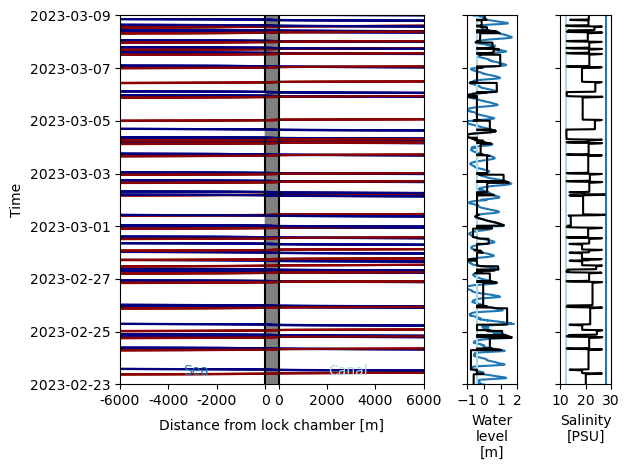

In [35]:
start_node = '5mile'
end_node = 'Houtrak'
lock = lock_I
xlim_distance_to_lock_doors_A = -6000
xlim_distance_to_lock_doors_B = 6000
distance_ticks = 2000

substring_matches = ["Sailing from node","to node"]
vessel_times = []
vessel_distances = []
vessel_colors = []
for vessel_index,vessel in enumerate(vessels):
    vessel_df = pd.DataFrame(vessel.logbook)
    side = None
    lock_reached = False
    lock_passed = False
    approaching = 1
    direction = None
    color = None
    times = []
    distances = []
    for _,message in vessel_df.iterrows():
        node_start = None
        node_stop = None
        if all(x in message.Message for x in substring_matches):
            if not color and side != None:
                if not side:
                    color = 'darkred'
                elif side:
                    color = 'navy'
                    
            if message.Message == f'Sailing from node {lock.start_node} to node {lock.end_node} stop':
                lock_reached = True
            elif message.Message == f'Sailing from node {lock.end_node} to node {lock.start_node} stop':
                lock_reached = True
            
            m_start = re.search('Sailing from node (.+?) to node (.+?) start', message.Message)
            m_stop = re.search('Sailing from node (.+?) to node (.+?) stop', message.Message)
            if m_start:
                node_start = m_start.group(1)
                node_stop = m_start.group(2)
            elif m_stop:
                node_start = m_stop.group(1)
                node_stop = m_stop.group(2)
            
            if not (node_start == None or node_stop == None):
                if node_start == start_node:
                    side = 0
                elif node_start == end_node:
                    side = 1
    
                if direction == None and side != None:
                    direction = side
    
                lock_start_node = lock.start_node
                lock_end_node = lock.end_node
                lock_correction_start = lock.distance_from_start_node_to_lock_doors_A + 0.5*lock.lock_length
                lock_correction_stop = -(lock.distance_from_end_node_to_lock_doors_B + 0.5*lock.lock_length)
                sign = -1
                if direction:
                    lock_correction_stop, lock_correction_start = lock_correction_start, lock_correction_stop                
                    sign = 1
                    lock_start_node = lock.end_node
                    lock_end_node = lock.start_node
                    
                edge = (node_start,node_stop)
                
                distance_to_lock = 0
                distance_from_lock = 0
                if not lock_reached:
                    route = nx.dijkstra_path(vessel.env.FG,node_start,lock_start_node)
                    if m_start:
                        distance_to_lock = vessel.env.vessel_traffic_service.provide_sailing_distance_over_route(route)['Distance'].sum()
                    if m_stop:
                        distance_to_lock = vessel.env.vessel_traffic_service.provide_sailing_distance_over_route(route[1:])['Distance'].sum()
                    distances.append(sign*distance_to_lock-lock_correction_start)
                    times.append(message.Timestamp)
                else:
                    sign = -1*sign
                    route = nx.dijkstra_path(vessel.env.FG,lock_end_node,node_stop)
                    if m_start:
                        distance_from_lock = vessel.env.vessel_traffic_service.provide_sailing_distance_over_route(route[:-1])['Distance'].sum()
                    if m_stop:
                        distance_from_lock = vessel.env.vessel_traffic_service.provide_sailing_distance_over_route(route)['Distance'].sum()
                    distances.append(sign*distance_from_lock-lock_correction_stop)
                    times.append(message.Timestamp)
        elif 'Waiting' in message.Message:
            distances.append(distances[-1])
            times.append(message.Timestamp)
        else:
            if not side:
                distance_sailed,_ = vessel.env.vessel_traffic_service.provide_distance_over_network_to_location(lock.start_node,lock.end_node,message.Geometry)
                distance_sailed -= lock.distance_from_start_node_to_lock_doors_A + 0.5*lock.lock_length
            elif side:
                distance_sailed,_ = vessel.env.vessel_traffic_service.provide_distance_over_network_to_location(lock.end_node,lock.start_node,message.Geometry)
                distance_sailed = lock.distance_from_end_node_to_lock_doors_B + 0.5*lock.lock_length - distance_sailed
                
            distances.append(distance_sailed)
            times.append(message.Timestamp)
        
    vessel_distances.append(distances)
    vessel_times.append(times)
    vessel_colors.append(color)

fig,axes = plt.subplots(1,3,width_ratios=[6, 1, 1])
ax = axes[0]
first_message_info = lock_df.iloc[0]
simulation_start = pd.Timestamp(vessel.env.simulation_start)
simulation_stop = pd.Timestamp(vessel.env.simulation_stop)

door_closed_A = [[simulation_start]]
door_closed_B = [[simulation_start]]
replacement_wlev = pd.DataFrame(data={'Water level':lock.water_level},index=hydrodynamic_times)
nr_openings = 0
nr_closings = 0
nr_conversions = 0
for loc,info in lock_df.iterrows():   
    if info.name == 0:
        ylim_min = info.Timestamp - pd.Timedelta(minutes=5)
    if info.Message == 'Lock doors opening start': 
        nr_openings += 1
        door_opening_start = lock_df.loc[loc].Timestamp
        if info.name != len(lock_df)-1:
            door_opening_stop = lock_df.loc[loc+1].Timestamp
        else:
            door_opening_stop = simulation_stop   

        direction = info.Geometry
        if info.name != 0 and lock_df.loc[loc-2].Geometry != direction:
            if direction == lock.start_node:
                color_doors = 'cornflowerblue'
                door_closed_A[-1].extend([door_opening_stop])
            else:
                color_doors = 'lightcoral'
                door_closed_B[-1].extend([door_opening_stop])    
        else:
            if direction == lock.start_node:
                color_doors = 'lightcoral'
                door_closed_A[-1].extend([door_opening_stop])
            else:
                color_doors = 'cornflowerblue'
                door_closed_B[-1].extend([door_opening_stop])
                
        ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                [door_opening_start,door_opening_stop,door_opening_stop,door_opening_start],
                color=color_doors,edgecolor='none',zorder=2)

        if info.name == 0:
            ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                    [simulation_start,door_opening_start,door_opening_start,simulation_start],
                    color='grey',edgecolor='none',zorder=2)
        else:
            door_closing_stop = lock_df.loc[loc-1].Timestamp
            ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                    [door_opening_start,door_closing_stop,door_closing_stop,door_opening_start],
                    color='grey',edgecolor='none',zorder=2)

    if info.Message == 'Lock doors closing start':
        nr_closings += 1
        door_closing_start = lock_df.loc[loc].Timestamp
        if info.name != len(lock_df)-1:
            door_closing_stop = lock_df.loc[loc+1].Timestamp
        else:
            door_closing_stop = simulation_stop
            
        direction = lock_df.loc[loc].Geometry

        if direction == lock.start_node:
            door_closed_A.append([door_closing_start])
            color_doors = 'lightcoral'
        else:
            door_closed_B.append([door_closing_start]) 
            color_doors = 'cornflowerblue'
            
        ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                [door_closing_start,door_closing_stop,door_closing_stop,door_closing_start],
                color=color_doors,edgecolor='none',zorder=2)

        if info.name == len(lock_df)-2:
            ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                    [door_closing_stop,simulation_stop,simulation_stop,door_closing_stop],
                    color='grey',edgecolor='none',zorder=2)
            ylim_max = door_closing_stop + pd.Timedelta(minutes=5)

    if info.Message == 'Lock chamber converting start':
        nr_conversions += 1
        levelling_start = lock_df.loc[loc].Timestamp
        if info.name != len(lock_df)-1:
            levelling_stop = lock_df.loc[loc+1].Timestamp
        else:
            levelling_stop = simulation_stop
            
        direction = lock_df.loc[loc].Geometry   
        if direction == lock.start_node:
            direction = 0
            color_levelling = 'indianred'
        else:
            direction = 1
            color_levelling = 'royalblue'

        same_direction = False
        if lock_df.loc[loc].Geometry == lock_df.loc[loc+1].Geometry:
            same_direction = True

        ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                [levelling_start,levelling_stop,levelling_stop,levelling_start],
                color=color_levelling,edgecolor='none',zorder=2)

        if loc != 0:
            door_closing_stop = lock_df.loc[loc-1].Timestamp
            ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                    [door_closing_stop,levelling_start,levelling_start,door_closing_stop],
                    color='grey',edgecolor='none',zorder=2)
            ylim_max = door_closing_stop + pd.Timedelta(minutes=5)
        else:
            doors_closed_open = lock.env.simulation_start
            doors_closed_stop = lock_df.loc[loc].Timestamp
            ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                    [doors_closed_open,doors_closed_stop,doors_closed_stop,doors_closed_open],
                    color='grey',edgecolor='none',zorder=2)

        tstart = np.datetime64(levelling_start)
        tstop = np.datetime64(levelling_stop)     
        t_index_stop = int(np.absolute(hydrodynamic_times - tstop).argmin())
        t_index_start = int(np.absolute(hydrodynamic_times - tstart).argmin())
        if t_index_start == t_index_stop:
            t_index_start -= 1
        wlevstart = lock.water_level[t_index_start+1]
        wlevstop = lock.water_level[t_index_stop]   
        tstep = pd.Timedelta(seconds=lock.time_step)
        _,z = lock.determine_levelling_time(t_start=tstart,wlev_init=wlevstart,same_direction=same_direction,direction=direction,prediction=True)
        z = z[~np.isnan(z)]
        wlev_diff0 = wlevstop - z[0] - wlevstart
        levelling_wlev = (wlevstop - z - wlev_diff0)
        levelling_times = np.datetime64(tstart) + np.arange(len(z))*tstep
        levelling_df = pd.DataFrame(data={'Water level':levelling_wlev},index=levelling_times)
        replacement_wlev = replacement_wlev.drop(replacement_wlev[(replacement_wlev.index >= tstart)&(replacement_wlev.index <= tstop)].index)
        replacement_wlev = pd.concat([replacement_wlev,levelling_df])
        replacement_wlev = replacement_wlev.sort_index()
        
for distances,times,color in zip(vessel_distances,vessel_times,vessel_colors):
    ax.plot(distances,times,color=color)

if len(door_closed_A[0]) == 1:
    simulation_stop = pd.Timestamp(datetime.datetime.fromtimestamp(vessel.env.now))
    door_closed_A[0].extend([simulation_start])
if len(door_closed_B[0]) == 1:
    simulation_stop = pd.Timestamp(datetime.datetime.fromtimestamp(vessel.env.now))
    door_closed_B[0].extend([simulation_start])
if len(door_closed_A[-1]) == 1:
    simulation_stop = pd.Timestamp(datetime.datetime.fromtimestamp(vessel.env.now))
    door_closed_A[-1].extend([simulation_stop])
if len(door_closed_B[-1]) == 1:
    simulation_stop = pd.Timestamp(datetime.datetime.fromtimestamp(vessel.env.now))
    door_closed_B[-1].extend([simulation_stop])

for door_closed in door_closed_A:
    ax.plot([-lock.lock_length/2,-lock.lock_length/2],door_closed,color='k')

for door_closed in door_closed_B:
    ax.plot([lock.lock_length/2,lock.lock_length/2],door_closed,color='k')

ylim_min = pd.Timestamp('2023-02-23 00:00:00')
ylim_max = pd.Timestamp('2023-03-09 00:00:00')

ax.axvline(-lock.lock_length/2,color='lightgrey',zorder=1)
ax.axvline(lock.lock_length/2,color='lightgrey',zorder=1)

xticklabels_approach_A = np.arange(xlim_distance_to_lock_doors_A,0+distance_ticks,distance_ticks)
xticklabels_approach_B = np.arange(0,xlim_distance_to_lock_doors_B+distance_ticks,distance_ticks)
xticks_approach_A = [tick-lock.lock_length/2 for tick in xticklabels_approach_A]
xticks_approach_B = [tick+lock.lock_length/2 for tick in xticklabels_approach_B]
xticks = np.append(xticks_approach_A,xticks_approach_B)
xticklabels = np.append(xticklabels_approach_A,xticklabels_approach_B)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlim(xlim_distance_to_lock_doors_A-lock.lock_length/2,xlim_distance_to_lock_doors_B+lock.lock_length/2)
ax.set_ylim(ylim_min,ylim_max)
ax.annotate(xy=(0.25,0.025),text='Sea',xycoords='axes fraction',horizontalalignment='center',color='C0')
ax.annotate(xy=(0.75,0.025),text='Canal',xycoords='axes fraction',horizontalalignment='center',color='lightblue')
ax.set_xlabel('Distance from lock chamber [m]',labelpad=8)
ax.set_ylabel('Time');

ax = axes[1]
ax.plot(hydrodynamic_data['Water level'][0].values,hydrodynamic_data.TIME,color='C0')
ax.plot(hydrodynamic_data['Water level'][1].values,hydrodynamic_data.TIME,color='lightblue')
ax.plot(replacement_wlev.values,replacement_wlev.index,color='k')
ax.set_xlim(-1.0,2.0)
ax.set_xticks(np.arange(-1,3,1))
ax.set_ylim(ylim_min,ylim_max)
ax.set_yticklabels([])
ax.set_xlabel('Water\nlevel\n[m]');

ax = axes[2]
ax.axvline(28,color='C0')
ax.axvline(12,color='lightblue')
ax.plot(lock_salinity,hydrodynamic_data.TIME,color='k')
ax.set_xlim(10,30)
ax.set_ylim(ylim_min,ylim_max)
ax.set_yticklabels([])
ax.set_xlabel('Salinity\n[PSU]')

fig.tight_layout()
fig.savefig(output_path+'not_reducing_door_open_time.png',format='png',dpi=500);

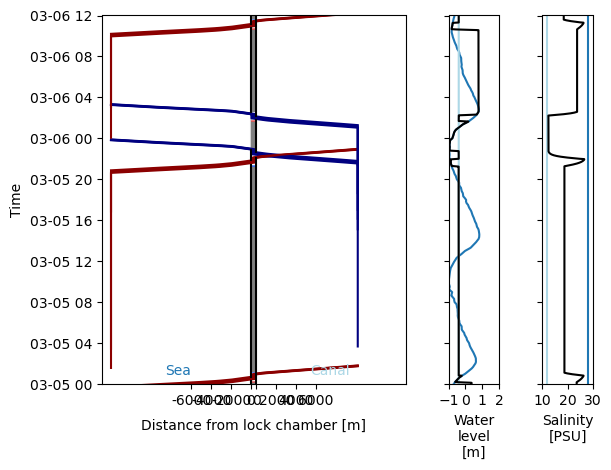

In [36]:
for index,ax in enumerate(axes):
    ymin = pd.Timestamp('2023-03-05 00:00:00')
    ymax = pd.Timestamp('2023-03-06 12:00:00')
    ax.set_ylim(ymin,ymax)
        
axes[0].set_xlim(-15000-545/2,15000+545/2)
axes[1].set_xlim(-1,2)
fig
#fig.savefig(output_path+'simple_lock_passage_2way.png',format='png',dpi=500);

In [37]:
operation_planning

,bound,vessels,capacity_L,capacity_B,time_potential_lock_door_opening_stop,time_operation_start,time_entry_start,time_entry_stop,time_door_closing_start,time_door_closing_stop,...,time_door_opening_stop,time_departure_start,time_departure_stop,time_operation_stop,time_potential_lock_door_closure_start,wlev_A,wlev_B,maximum_individual_delay,total_delay,status
lock_operation,,,,,,,,,,,,,,,,,,,,,
0,0,[<__main__.Vessel object at 0x0000024F3B3C53C0...,145,-130,2023-02-23 09:19:49.073664842,2023-02-23 09:22:31.708276189,2023-02-23 09:30:37.669819136,2023-02-23 09:47:12.432320010,2023-02-23 09:47:26.265973430,2023-02-23 09:51:56.265973430,...,2023-02-23 09:59:06.265973430,2023-02-23 10:00:50.002512295,2023-02-23 10:05:51.298668921,2023-02-23 10:13:57.260211868,2023-02-23 10:07:39.894823215,-0.07,-0.4,0 days 12:17:53.217160,1 days 06:12:41.217160,not available
1,1,[<__main__.Vessel object at 0x0000024F3B3C7AC0...,145,-130,2023-02-23 12:48:15.745971959,2023-02-23 12:50:58.380583306,2023-02-23 12:59:04.342126253,2023-02-23 13:15:39.104627127,2023-02-23 13:15:52.938280547,2023-02-23 13:20:22.938280547,...,2023-02-23 13:27:37.938280547,2023-02-23 13:29:21.674819412,2023-02-23 13:34:22.970976038,2023-02-23 13:42:28.932518985,2023-02-23 13:36:11.567130332,-0.743,-0.4,0 days 12:15:46.363916648,1 days 07:08:40.585593040,not available
2,0,[<__main__.Vessel object at 0x0000024F3B3C7EE0...,145,-130,2023-02-24 07:17:32.073664842,2023-02-24 07:20:14.708276189,2023-02-24 07:28:20.669819136,2023-02-24 07:44:55.432320010,2023-02-24 07:45:09.265973430,2023-02-24 07:49:39.265973430,...,2023-02-24 07:59:19.265973430,2023-02-24 08:01:03.002512295,2023-02-24 08:06:04.298668921,2023-02-24 08:14:10.260211868,2023-02-24 08:07:52.894823215,0.81,-0.4,1 days 10:27:05.217160,3 days 03:37:50.217160,ready
3,1,[<__main__.Vessel object at 0x0000024F3B440C70...,145,-130,2023-02-24 08:07:52.894823215,2023-02-24 08:10:35.529434562,2023-02-24 08:18:41.490977509,2023-02-24 08:35:16.253478383,2023-02-24 08:35:30.087131803,2023-02-24 08:40:00.087131803,...,2023-02-24 08:49:00.087131803,2023-02-24 08:50:43.823670668,2023-02-24 08:55:45.119827294,2023-02-24 09:03:51.081370241,2023-02-24 08:57:33.715981588,0.838,-0.4,0 days 09:30:30.813314256,0 days 20:56:03.595405024,not available
4,0,[<__main__.Vessel object at 0x0000024F3B4422F0...,145,-130,2023-02-24 18:23:02.965084842,2023-02-24 18:25:45.599696189,2023-02-24 18:33:51.561239136,2023-02-24 18:50:26.323740010,2023-02-24 18:50:40.157393430,2023-02-24 18:55:10.157393430,...,2023-02-24 19:06:25.157393430,2023-02-24 19:08:08.893932295,2023-02-24 19:13:10.190088921,2023-02-24 19:21:16.151631868,2023-02-24 19:14:58.786243215,1.635,-0.4,0 days 19:01:44.036651896,1 days 22:45:27.819491896,ready
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1,[<__main__.Vessel object at 0x0000024F3BAC31F0...,145,-130,2023-03-08 14:17:43.410434959,2023-03-08 14:20:26.045046306,2023-03-08 14:28:32.006589253,2023-03-08 14:45:06.769090127,2023-03-08 14:45:20.602743547,2023-03-08 14:49:50.602743547,...,2023-03-08 14:56:45.602743547,2023-03-08 14:58:29.339282412,2023-03-08 15:03:30.635439038,2023-03-08 15:11:36.596981985,2023-03-08 15:05:19.231593332,-0.144,-0.4,0 days 04:27:54.242973205,0 days 09:42:01.603122693,ready
76,0,[],545,70,2023-03-08 16:06:35.745971959,2023-03-08 16:06:35.745971959,2023-03-08 16:06:35.745971959,2023-03-08 16:06:35.745971959,2023-03-08 16:06:35.745971959,2023-03-08 16:11:05.745971959,...,2023-03-08 16:11:05.745971959,2023-03-08 16:11:05.745971959,2023-03-08 16:11:05.745971959,2023-03-08 16:11:05.745971959,2023-03-08 16:11:05.745971959,1.005,-0.4,0 days 00:00:00,0 days 00:00:00,not available
77,1,[<__main__.Vessel object at 0x0000024F3BAED690...,145,-130,2023-03-08 19:32:03.410434959,2023-03-08 19:34:46.045046306,2023-03-08 19:42:52.006589253,2023-03-08 19:59:26.769090127,2023-03-08 19:59:40.602743547,2023-03-08 20:04:10.602743547,...,2023-03-08 20:12:15.602743547,2023-03-08 20:13:59.3

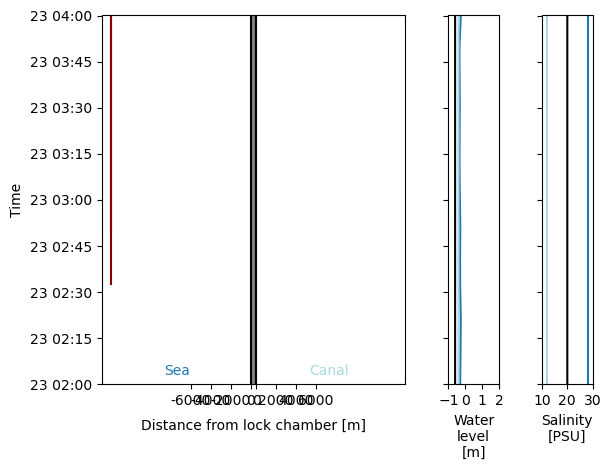

In [38]:
for index,ax in enumerate(axes):
    ymin = pd.Timestamp('2023-02-23 02:00:00')
    ymax = pd.Timestamp('2023-02-23 04:00:00')
    ax.set_ylim(ymin,ymax)
        
axes[0].set_xlim(-15000-545/2,15000+545/2)
axes[1].set_xlim(-1,2)
fig
#fig.savefig(output_path+'simple_lock_passage_2way.png',format='png',dpi=500);

In [39]:
lock_df

,Message,Timestamp,Value,Geometry
0,Lock chamber converting start,2023-02-23 09:11:44.073664,{},lock_sea
1,Lock chamber converting stop,2023-02-23 09:15:24.073664,{},lock_sea
2,Lock doors opening start,2023-02-23 09:15:24.073664,{},lock_sea
3,Lock doors opening stop,2023-02-23 09:19:54.073664,{},lock_sea
4,Lock doors closing start,2023-02-23 09:47:12.432320,{},lock_sea
...,...,...,...,...
607,Lock chamber converting stop,2023-03-09 00:53:52.938280,{},lock_sea
608,Lock doors opening start,2023-03-09 00:53:52.938280,{},lock_sea
609,Lock doors opening stop,2023-03-09 00:58:22.938280,{},lock_sea
610,Lock doors closing start,2023-03-09 01:03:51.901744,{},lock_sea


In [40]:
operation_planning

,bound,vessels,capacity_L,capacity_B,time_potential_lock_door_opening_stop,time_operation_start,time_entry_start,time_entry_stop,time_door_closing_start,time_door_closing_stop,...,time_door_opening_stop,time_departure_start,time_departure_stop,time_operation_stop,time_potential_lock_door_closure_start,wlev_A,wlev_B,maximum_individual_delay,total_delay,status
lock_operation,,,,,,,,,,,,,,,,,,,,,
0,0,[<__main__.Vessel object at 0x0000024F3B3C53C0...,145,-130,2023-02-23 09:19:49.073664842,2023-02-23 09:22:31.708276189,2023-02-23 09:30:37.669819136,2023-02-23 09:47:12.432320010,2023-02-23 09:47:26.265973430,2023-02-23 09:51:56.265973430,...,2023-02-23 09:59:06.265973430,2023-02-23 10:00:50.002512295,2023-02-23 10:05:51.298668921,2023-02-23 10:13:57.260211868,2023-02-23 10:07:39.894823215,-0.07,-0.4,0 days 12:17:53.217160,1 days 06:12:41.217160,not available
1,1,[<__main__.Vessel object at 0x0000024F3B3C7AC0...,145,-130,2023-02-23 12:48:15.745971959,2023-02-23 12:50:58.380583306,2023-02-23 12:59:04.342126253,2023-02-23 13:15:39.104627127,2023-02-23 13:15:52.938280547,2023-02-23 13:20:22.938280547,...,2023-02-23 13:27:37.938280547,2023-02-23 13:29:21.674819412,2023-02-23 13:34:22.970976038,2023-02-23 13:42:28.932518985,2023-02-23 13:36:11.567130332,-0.743,-0.4,0 days 12:15:46.363916648,1 days 07:08:40.585593040,not available
2,0,[<__main__.Vessel object at 0x0000024F3B3C7EE0...,145,-130,2023-02-24 07:17:32.073664842,2023-02-24 07:20:14.708276189,2023-02-24 07:28:20.669819136,2023-02-24 07:44:55.432320010,2023-02-24 07:45:09.265973430,2023-02-24 07:49:39.265973430,...,2023-02-24 07:59:19.265973430,2023-02-24 08:01:03.002512295,2023-02-24 08:06:04.298668921,2023-02-24 08:14:10.260211868,2023-02-24 08:07:52.894823215,0.81,-0.4,1 days 10:27:05.217160,3 days 03:37:50.217160,ready
3,1,[<__main__.Vessel object at 0x0000024F3B440C70...,145,-130,2023-02-24 08:07:52.894823215,2023-02-24 08:10:35.529434562,2023-02-24 08:18:41.490977509,2023-02-24 08:35:16.253478383,2023-02-24 08:35:30.087131803,2023-02-24 08:40:00.087131803,...,2023-02-24 08:49:00.087131803,2023-02-24 08:50:43.823670668,2023-02-24 08:55:45.119827294,2023-02-24 09:03:51.081370241,2023-02-24 08:57:33.715981588,0.838,-0.4,0 days 09:30:30.813314256,0 days 20:56:03.595405024,not available
4,0,[<__main__.Vessel object at 0x0000024F3B4422F0...,145,-130,2023-02-24 18:23:02.965084842,2023-02-24 18:25:45.599696189,2023-02-24 18:33:51.561239136,2023-02-24 18:50:26.323740010,2023-02-24 18:50:40.157393430,2023-02-24 18:55:10.157393430,...,2023-02-24 19:06:25.157393430,2023-02-24 19:08:08.893932295,2023-02-24 19:13:10.190088921,2023-02-24 19:21:16.151631868,2023-02-24 19:14:58.786243215,1.635,-0.4,0 days 19:01:44.036651896,1 days 22:45:27.819491896,ready
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1,[<__main__.Vessel object at 0x0000024F3BAC31F0...,145,-130,2023-03-08 14:17:43.410434959,2023-03-08 14:20:26.045046306,2023-03-08 14:28:32.006589253,2023-03-08 14:45:06.769090127,2023-03-08 14:45:20.602743547,2023-03-08 14:49:50.602743547,...,2023-03-08 14:56:45.602743547,2023-03-08 14:58:29.339282412,2023-03-08 15:03:30.635439038,2023-03-08 15:11:36.596981985,2023-03-08 15:05:19.231593332,-0.144,-0.4,0 days 04:27:54.242973205,0 days 09:42:01.603122693,ready
76,0,[],545,70,2023-03-08 16:06:35.745971959,2023-03-08 16:06:35.745971959,2023-03-08 16:06:35.745971959,2023-03-08 16:06:35.745971959,2023-03-08 16:06:35.745971959,2023-03-08 16:11:05.745971959,...,2023-03-08 16:11:05.745971959,2023-03-08 16:11:05.745971959,2023-03-08 16:11:05.745971959,2023-03-08 16:11:05.745971959,2023-03-08 16:11:05.745971959,1.005,-0.4,0 days 00:00:00,0 days 00:00:00,not available
77,1,[<__main__.Vessel object at 0x0000024F3BAED690...,145,-130,2023-03-08 19:32:03.410434959,2023-03-08 19:34:46.045046306,2023-03-08 19:42:52.006589253,2023-03-08 19:59:26.769090127,2023-03-08 19:59:40.602743547,2023-03-08 20:04:10.602743547,...,2023-03-08 20:12:15.602743547,2023-03-08 20:13:59.3

In [41]:
vessel_planning[vessel_planning.operation_index == 0]

,bound,L,B,T,operation_index,time_of_registration,time_of_acceptance,time_arrival_at_waiting_area,time_arrival_at_lineup_area,time_lock_passing_start,time_lock_entry_start,time_lock_entry_stop,time_lock_departure_start,time_lock_departure_stop,time_lock_passing_stop,delay,time_potential_lock_door_opening_stop,time_potential_lock_door_closure_start
id,,,,,,,,,,,,,,,,,,
9c96b283-0c7f-4705-8229-fa23eeb5dbc4,0,100,50,7.8,0,2023-02-23 02:32:40.891420,2023-02-23 02:32:40.891420,2023-02-23 09:01:13.644071865,2023-02-23 09:01:57.424391049,2023-02-23 09:22:31.708276189,2023-02-23 09:30:37.669819136,2023-02-23 09:34:38.220782894,2023-02-23 10:00:50.002512295,2023-02-23 10:02:58.037128307,2023-02-23 10:13:12.033287266,0 days 12:17:53.217160,2023-02-23 09:19:49.073664842,2023-02-23 09:32:26.265973430
092a7ded-5ce7-4bf4-9e52-deac86431966,0,100,50,12.8,0,2023-02-23 02:49:57,2023-02-23 02:49:57,2023-02-23 09:06:13.644071865,2023-02-23 09:06:57.424391049,2023-02-23 09:27:31.708276189,2023-02-23 09:35:37.669819136,2023-02-23 09:38:49.624628600,2023-02-23 10:01:33.739051160,2023-02-23 10:02:46.633282602,2023-02-23 10:10:52.594825549,0 days 11:48:01,2023-02-23 09:24:49.073664842,2023-02-23 09:37:26.265973430
3e603346-fbdb-4396-937f-418c71b30681,0,100,50,11.4,0,2023-02-23 05:40:54,2023-02-23 05:40:54,2023-02-23 09:11:13.644071865,2023-02-23 09:11:57.424391049,2023-02-23 09:32:31.708276189,2023-02-23 09:40:37.669819136,2023-02-23 09:43:01.028474305,2023-02-23 10:02:17.475590025,2023-02-23 10:04:18.965975761,2023-02-23 10:12:24.927518708,0 days 06:06:47,2023-02-23 09:29:49.073664842,2023-02-23 09:42:26.265973430
5afd19b1-3971-4490-88b1-8d09dfa1282c,0,100,50,9.2,0,2023-02-23 08:48:15,2023-02-23 08:48:15,2023-02-23 09:16:13.644071865,2023-02-23 09:16:57.424391049,2023-02-23 09:37:31.708276189,2023-02-23 09:45:37.669819136,2023-02-23 09:47:12.432320010,2023-02-23 10:03:01.212128890,2023-02-23 10:05:51.298668921,2023-02-23 10:13:57.260211868,0 days 00:00:00,2023-02-23 09:34:49.073664842,2023-02-23 09:47:26.265973430


In [42]:
operation_planning.loc[32:35]

,bound,vessels,capacity_L,capacity_B,time_potential_lock_door_opening_stop,time_operation_start,time_entry_start,time_entry_stop,time_door_closing_start,time_door_closing_stop,...,time_door_opening_stop,time_departure_start,time_departure_stop,time_operation_stop,time_potential_lock_door_closure_start,wlev_A,wlev_B,maximum_individual_delay,total_delay,status
lock_operation,,,,,,,,,,,,,,,,,,,,,
32,0,[],545,70,2023-02-28 23:39:18.715981588,2023-02-28 23:39:18.715981588,2023-02-28 23:39:18.715981588,2023-02-28 23:39:18.715981588,2023-02-28 23:41:07.312135882,2023-02-28 23:45:37.312135882,...,2023-02-28 23:54:02.312135882,2023-02-28 23:54:02.312135882,2023-02-28 23:54:02.312135882,2023-02-28 23:54:02.312135882,2023-02-28 23:54:02.312135882,0.385,-0.4,0 days 02:24:27.745005550,0 days 00:00:00,not available
33,1,[<__main__.Vessel object at 0x0000024F3B96D0C0...,145,-130,2023-02-28 23:54:02.312135882,2023-02-28 23:56:44.946747229,2023-03-01 00:04:50.908290176,2023-03-01 00:21:25.670791050,2023-03-01 00:21:39.504444470,2023-03-01 00:26:09.504444470,...,2023-03-01 00:36:29.504444470,2023-03-01 00:38:13.240983335,2023-03-01 00:43:14.537139961,2023-03-01 00:51:20.498682908,2023-03-01 00:45:03.133294255,1.142,-0.4,0 days 02:50:33.014228244,0 days 08:17:22.719331013,ready
34,0,[],545,70,2023-03-01 00:45:03.133294255,2023-03-01 00:45:03.133294255,2023-03-01 00:45:03.133294255,2023-03-01 00:45:03.133294255,2023-03-01 00:45:03.133294255,2023-03-01 00:49:33.133294255,...,2023-03-01 00:59:58.133294255,2023-03-01 00:59:58.133294255,2023-03-01 00:59:58.133294255,2023-03-01 00:59:58.133294255,2023-03-01 00:59:58.133294255,1.2,-0.4,0 days 00:00:00,0 days 00:00:00,not available
35,1,[<__main__.Vessel object at 0x0000024F3B96E740...,145,-130,2023-03-01 09:12:48.410434959,2023-03-01 09:15:31.045046306,2023-03-01 09:23:37.006589253,2023-03-01 09:40:11.769090127,2023-03-01 09:40:25.602743547,2023-03-01 09:44:55.602743547,...,2023-03-01 09:49:30.602743547,2023-03-01 09:51:14.339282412,2023-03-01 09:56:15.635439038,2023-03-01 10:04:21.596981985,2023-03-01 09:58:04.231593332,-0.425,-0.4,0 days 16:46:20.823504102,1 days 07:28:09.152430102,ready


In [43]:
vessel_planning[vessel_planning.operation_index == 33]

,bound,L,B,T,operation_index,time_of_registration,time_of_acceptance,time_arrival_at_waiting_area,time_arrival_at_lineup_area,time_lock_passing_start,time_lock_entry_start,time_lock_entry_stop,time_lock_departure_start,time_lock_departure_stop,time_lock_passing_stop,delay,time_potential_lock_door_opening_stop,time_potential_lock_door_closure_start
id,,,,,,,,,,,,,,,,,,
a0080c34-5eba-462e-9851-6aeb2fcb227d,1,100,50,7.0,33,2023-02-28 20:22:05,2023-02-28 20:22:05,2023-02-28 23:09:20.297720160,2023-02-28 23:10:12.272216732,2023-02-28 23:56:44.946747229,2023-03-01 00:04:50.908290176,2023-03-01 00:08:51.459253934,2023-03-01 00:38:13.240983335,2023-03-01 00:40:21.275599347,2023-03-01 00:50:35.271758306,0 days 02:50:33.014228244,2023-02-28 23:54:02.312135882,2023-03-01 00:06:39.504444470
cff06cca-a264-4cd1-affe-5aca51d7b969,1,100,50,13.8,33,2023-02-28 21:31:29.664463,2023-02-28 21:31:29.664463,2023-02-28 21:54:17.217177610,2023-02-28 21:55:09.191674182,2023-03-01 00:01:44.946747229,2023-03-01 00:09:50.908290176,2023-03-01 00:13:02.863099640,2023-03-01 00:38:56.977522200,2023-03-01 00:40:09.871753642,2023-03-01 00:48:15.833296589,0 days 01:57:28.901700923,2023-02-28 23:59:02.312135882,2023-03-01 00:11:39.504444470
dcd94986-8c2c-4b2a-981e-d302f173f70b,1,100,50,6.8,33,2023-02-28 21:35:47.664463,2023-02-28 21:35:47.664463,2023-02-28 21:58:35.217177610,2023-02-28 21:59:27.191674182,2023-03-01 00:06:44.946747229,2023-03-01 00:14:50.908290176,2023-03-01 00:17:14.266945345,2023-03-01 00:39:40.714061065,2023-03-01 00:41:42.204446801,2023-03-01 00:49:48.165989748,0 days 01:53:10.901700923,2023-03-01 00:04:02.312135882,2023-03-01 00:16:39.504444470
408b1013-a27e-45fb-944d-c7ed84737bbb,1,100,50,7.0,33,2023-02-28 21:52:48.664463,2023-02-28 21:52:48.664463,2023-02-28 22:15:36.217177610,2023-02-28 22:16:28.191674182,2023-03-01 00:11:44.946747229,2023-03-01 00:19:50.908290176,2023-03-01 00:21:25.670791050,2023-03-01 00:40:24.450599930,2023-03-01 00:43:14.537139961,2023-03-01 00:51:20.498682908,0 days 01:36:09.901700923,2023-03-01 00:09:02.312135882,2023-03-01 00:21:39.504444470


In [44]:
lock_df.iloc[-50:]

,Message,Timestamp,Value,Geometry
562,Lock doors opening start,2023-03-08 09:53:07.312135,{},lock_lake
563,Lock doors opening stop,2023-03-08 09:57:37.312135,{},lock_lake
564,Lock doors closing start,2023-03-08 10:20:30.670790,{},lock_lake
565,Lock doors closing stop,2023-03-08 10:25:00.670790,{},lock_lake
566,Lock chamber converting start,2023-03-08 10:25:00.670790,{},lock_lake
567,Lock chamber converting stop,2023-03-08 10:28:55.670790,{},lock_sea
568,Lock doors closing start,2023-03-08 10:42:13.133294,{},lock_sea
569,Lock doors closing stop,2023-03-08 10:46:43.133294,{},lock_sea
570,Lock chamber converting start,2023-03-08 13:16:55.073664,{},lock_sea
571,Lock chamber converting stop,2023-03-08 13:19:35.073664,{},lock_sea


In [45]:
non_empty_lockages = lock.operation_pre_planning[lock.operation_pre_planning.vessels.apply(len)>0]

In [46]:
previous_door_closed_stop = door_closed_A[0][1]
door_open_times_A = []
for times in door_closed_A[1:]:
    if len(times) == 2:
        door_closed_start,door_closed_stop = times
        door_open_times_A.append(door_closed_start-previous_door_closed_stop)
        previous_door_closed_stop = door_closed_stop

previous_door_closed_stop = door_closed_B[0][1]
door_open_times_B = []
for times in door_closed_B[1:]:
    if len(times) == 2:
        door_closed_start,door_closed_stop = times
        door_open_times_B.append(door_closed_start-previous_door_closed_stop)
        previous_door_closed_stop = door_closed_stop

In [47]:
distance_Houtrak_end_lock = env.vessel_traffic_service.provide_sailing_time(vessel=vessels[0],route=nx.dijkstra_path(env.FG,'Houtrak','lock_sea')).Time.sum()-lock.distance_from_start_node_to_lock_doors_A/env.vessel_traffic_service.provide_speed_over_edge(vessels[0],edge=['lock_lake','lock_sea',0])
distance_5mile_end_lock = env.vessel_traffic_service.provide_sailing_time(vessel=vessels[0],route=nx.dijkstra_path(env.FG,'5mile','lock_lake')).Time.sum()-lock.distance_from_end_node_to_lock_doors_B/env.vessel_traffic_service.provide_speed_over_edge(vessels[0],edge=['lock_sea','lock_lake',0])

In [48]:
inland_distance = env.vessel_traffic_service.provide_sailing_time(vessel=vessels[0],route=nx.dijkstra_path(env.FG,'Houtrak','5mile')).iloc[:7].Distance.sum()
sea_distance = env.vessel_traffic_service.provide_sailing_time(vessel=vessels[0],route=nx.dijkstra_path(env.FG,'Houtrak','5mile')).iloc[7:].Distance.sum()

In [49]:
env.vessel_traffic_service.provide_sailing_time(vessel=vessels[0],route=nx.dijkstra_path(env.FG,'Houtrak','5mile')).iloc[:7].Distance.sum()

12635.48626016756

In [50]:
distance_Houtrak_end_lock,distance_5mile_end_lock

(np.float64(3725.516010656499), np.float64(3830.873237442688))

In [51]:
planning = lock.vessel_planning
if lock.predictive:
    planning = lock.vessel_pre_planning

inbound_planning = planning[planning.bound == 0]
outbound_planning = planning[planning.bound == 1]
inbound_delays = inbound_planning.time_lock_departure_stop-inbound_planning.time_of_registration-pd.Timedelta(seconds=distance_5mile_end_lock)
outbound_delays = outbound_planning.time_lock_departure_stop-outbound_planning.time_of_registration-pd.Timedelta(seconds=distance_Houtrak_end_lock)
delays = pd.concat([inbound_delays,outbound_delays])

In [52]:
delays

id
9c96b283-0c7f-4705-8229-fa23eeb5dbc4    0 days 06:26:26.272470865
092a7ded-5ce7-4bf4-9e52-deac86431966    0 days 06:08:58.760045160
3e603346-fbdb-4396-937f-418c71b30681    0 days 03:19:34.092738319
5afd19b1-3971-4490-88b1-8d09dfa1282c    0 days 00:13:45.425431479
28e8b548-fefc-40cb-a188-e1747098447e    0 days 17:33:07.272470865
                                                  ...            
aec0ec9c-00ea-4680-bcc0-2f4995d9a855    0 days 03:04:12.789579063
44e01c32-20a2-4eac-ae3a-89122d55ac5c    0 days 01:04:29.786735222
bf71720b-ae7e-4139-9ebd-032ccb8d1f8d    0 days 00:09:55.454965382
2d9645e2-b632-4bee-a4d2-925b9e4e7ad6    0 days 02:43:03.193424768
bef1ff7f-5096-4745-a62e-fc99d2e62a1e    0 days 00:06:30.789579063
Length: 262, dtype: object

In [53]:
simulation_period = vessel_planning.iloc[-1].time_lock_passing_stop-vessel_planning.iloc[0].time_of_registration

In [54]:
door_open_times_A = np.array(door_open_times_A)[np.array(door_open_times_A) <= pd.Timedelta(1.5,'hours')]
door_open_times_B = np.array(door_open_times_B)[np.array(door_open_times_B) <= pd.Timedelta(1.5,'hours')]

In [55]:
print('lockage to canal:', non_empty_lockages.value_counts('bound')[0])
print('total lockages:',len(lock.operation_pre_planning))
print('door movements sea:',2*lock_df[lock_df.Geometry == 'lock_sea'].value_counts('Message')['Lock doors closing stop'])
print('door movements canal:',2*lock_df[lock_df.Geometry == 'lock_lake'].value_counts('Message')['Lock doors closing stop'])
print('mean door open time sea:',np.mean(door_open_times_A).total_seconds()/3600)
print('mean door open time canal:',np.mean(door_open_times_B).total_seconds()/3600)
print('total door open time sea %:',np.sum(door_open_times_A).total_seconds()/simulation_period.total_seconds()*100)
print('total door open time canal %:',np.sum(door_open_times_B).total_seconds()/simulation_period.total_seconds()*100)
print('median vessel delay:',np.median(delays.apply(lambda x: x.total_seconds()/3600)))
print('max vessel delay:',np.max(delays.apply(lambda x: x.total_seconds()/3600)))
#print('total intruded chloride vessels:',exchange_df[(exchange_df.Event == 'Sailing in')|(exchange_df.Event == 'Sailing out')].Exchange.sum()/(10**6))
#print('total intruded chloride levelling:',exchange_df[exchange_df.Event == 'Levelling'].Exchange.sum()/(10**6))
print('total intruded chloride mass:',exchange_df[exchange_df.Event == 'Door open'].Exchange.sum()/(10**6))
print('total intruded chloride mass:',exchange_df.Exchange.sum()/(10**6))
print('total intruded chloride mass (lockage equivalent):',exchange_df.Exchange.sum()/(((28/1.8-12/1.8)*545*70*17.75)))

lockage to canal: 28
total lockages: 80
door movements sea: 108
door movements canal: 94
mean door open time sea: 0.38110853694444446
mean door open time canal: 0.44035418583333336
total door open time sea %: 5.694569308861987
total door open time canal %: 6.185035380715352
median vessel delay: 4.820719954444444
max vessel delay: 30.359047009166666
total intruded chloride mass: -128.3114156411782
total intruded chloride mass: -172.52022296418528
total intruded chloride mass (lockage equivalent): -28.661547388508435


In [56]:
np.median(door_open_times_B).total_seconds()/3600,np.median(door_open_times_A).total_seconds()/3600

(0.45787740444444447, 0.4550996266666667)

In [57]:
np.mean(delays.apply(lambda x: x.total_seconds()/3600))

np.float64(6.13232868789016)

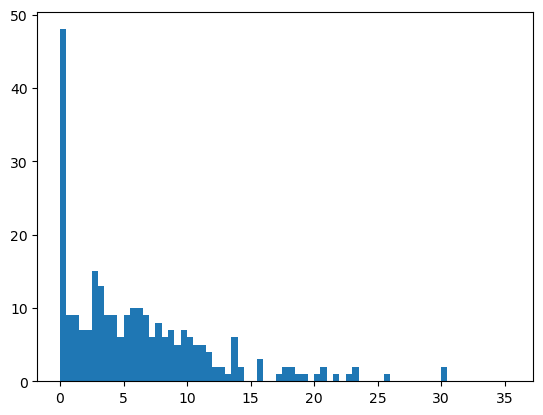

In [58]:
plt.hist(delays.apply(lambda x: x.total_seconds()/3600),bins=np.arange(0,36,0.5));

In [59]:
lock_df.iloc[-150:-100]

,Message,Timestamp,Value,Geometry
462,Lock doors opening start,2023-03-06 10:39:42.073664,{},lock_sea
463,Lock doors opening stop,2023-03-06 10:44:12.073664,{},lock_sea
464,Lock doors closing start,2023-03-06 11:11:35.432320,{},lock_sea
465,Lock doors closing stop,2023-03-06 11:16:05.432320,{},lock_sea
466,Lock chamber converting start,2023-03-06 11:16:05.432320,{},lock_sea
467,Lock chamber converting stop,2023-03-06 11:18:55.432320,{},lock_lake
468,Lock doors opening start,2023-03-06 11:18:55.432320,{},lock_lake
469,Lock doors opening stop,2023-03-06 11:23:25.432320,{},lock_lake
470,Lock doors closing start,2023-03-06 11:32:12.894823,{},lock_lake
471,Lock doors closing stop,2023-03-06 11:36:42.894823,{},lock_lake


In [60]:
exchange_df[exchange_df.Event == 'Door open'].Exchange

2                 0.0
6     -3561457.409966
9     -1537377.424876
13                0.0
17                0.0
            ...      
389               0.0
393   -2278684.379748
397               0.0
401   -2211512.217812
405               0.0
Name: Exchange, Length: 101, dtype: object

In [61]:
np.sum(delays.apply(lambda x: x.total_seconds()/3600))

np.float64(1606.670116227222)

In [62]:
registered_delays = pickle.load(open(path + "\\vessels\\observed_vessels.pickle",'rb'))

In [63]:
modelled_delays = pd.DataFrame()
for index,ID in enumerate(vessel_planning.index):
    modelled_delays.loc[index,'name'] = vessels[index].name
    modelled_delays.loc[index,'arrival_time'] = vessels_df.loc[index,'arrival_time']
    modelled_delays.loc[index,'bound'] = vessels_df.loc[index,'bound']
    modelled_delays.loc[index,'time_start'] = vessel_logbooks[index].loc[0,'Timestamp']
    modelled_delays.loc[index,'time_stop'] = vessel_logbooks[index].iloc[-1].Timestamp
    modelled_delays.loc[index,'delay'] = (modelled_delays.loc[index,'time_stop']-modelled_delays.loc[index,'time_start'])-pd.Timedelta(seconds=5987.517223415489)

In [64]:
modelled_delays

,name,arrival_time,bound,time_start,time_stop,delay
0,testschip-37707,2023-02-23 02:32:40.891420,inbound,2023-02-23 02:32:40.891420,2023-02-23 10:48:37.457716,0 days 06:36:09.049072585
1,testschip-36593,2023-02-23 02:49:57.000000,inbound,2023-02-23 02:49:57.000000,2023-02-23 10:50:09.790409,0 days 06:20:25.273185585
2,testschip-38412,2023-02-23 04:03:51.000000,outbound,2023-02-23 04:03:51.000000,2023-02-23 14:23:46.260798,0 days 08:40:07.743574585
3,testschip-38412,2023-02-23 04:38:18.664463,outbound,2023-02-23 04:38:18.664463,2023-02-23 14:25:18.593492,0 days 08:07:12.411805585
4,testschip-27669,2023-02-23 05:40:54.000000,inbound,2023-02-23 05:40:54.000000,2023-02-23 10:51:42.123102,0 days 03:31:00.605878585
...,...,...,...,...,...,...
257,testschip-28453,2023-03-08 16:09:37.664463,outbound,2023-03-08 16:09:37.664463,2023-03-08 21:09:56.257955,0 days 03:20:31.076268585
258,testschip-35772,2023-03-08 18:10:53.000000,outbound,2023-03-08 18:10:53.000000,2023-03-08 21:11:28.590648,0 days 01:20:48.073424585
259,testschip-35772,2023-03-08 19:06:59.664463,outbound,2023-03-08 19:06:59.664463,2023-03-08 21:13:00.923342,0 days 00:26:13.741655585
260,testschip-38607,2023-03-08 21:17:06.000000,outbound,2023-03-08 21:17:06.000000,2023-03-09 01:54:45.094452,0 days 02:57:51.577228585


In [65]:
for index,info in registered_delays.iterrows():
    if info.bound == 'inbound':
        if info.distance_start <= -sea_distance:
            sailing_time_sea = sea_distance/5.55
            remaining_distance = info.distance_start+sea_distance
        else:
            sailing_time_sea = -info.distance_start/5.55
            remaining_distance = 0

        sailing_time_inland = (info.distance_stop-remaining_distance)/3.33
  
    total_sailing_time = sailing_time_inland+sailing_time_sea
    registered_delays.loc[index,'delay'] = (registered_delays.loc[index,'time_stop']-registered_delays.loc[index,'time_start'])-np.timedelta64(pd.Timedelta(seconds=total_sailing_time),'s')

In [66]:
delay_diff = pd.DataFrame(columns=['name','delay'])
for index,info in registered_delays.iterrows():
    df = modelled_delays[(modelled_delays['name'] == info['name'])&(modelled_delays['arrival_time'] == info['arrival_time'])]
    if not df.empty:
        delay_diff.loc[index,:] = [info['name'],info.delay-df.iloc[0].delay]

In [67]:
np.median(delay_diff.delay)

Timedelta('-1 days +20:49:45.550767415')

In [68]:
np.mean(delay_diff.delay.apply(lambda x: x.total_seconds()/60))

np.float64(-286.7828986558265)

In [69]:
full_journeys = registered_delays[registered_delays.distance_start.isin([-14306.994469211164,10499.931084168276])&registered_delays.distance_stop.isin([-14306.994469211164,10470.642788020383])]

In [70]:
np.mean((full_journeys.time_stop-full_journeys.time_start)/np.timedelta64(1,'m'))

np.float64(153.70102040816326)

In [71]:
20/153

0.13071895424836602

In [2]:
vessel_delays = {0.5: 0.42,
                 1.0: 0.56,
                 2.0: 0.77,
                 3.0: 1.22,
                 4.0: 1.58,
                 5.0: 1.86,
                 6.0: 2.16,
                 8.0: 2.56,
                 10.0: 3.17,
                 12.0: 4.21,
                 24.0: 4.95,
                 36.0: 8.36}

intruded_mass = {0.5: 92.33,
                 1.0: 83.44,
                 2.0: 75.44,
                 3.0: 63.04,
                 4.0: 53.53,
                 5.0: 50.16,
                 6.0: 48.06,
                 8.0: 42.42,
                 10.0: 39.27,
                 12.0: 36.83,
                 24.0: 29.96,
                 36.0: 29.81}

vessel_delays_r = {0.5: 0.27,
                   1.0: 0.42,
                   2.0: 0.86,
                   3.0: 1.05,
                   4.0: 1.37,
                   5.0: 1.68,
                   6.0: 1.86,
                   8.0: 2.39,
                  10.0: 2.82,
                  12.0: 3.43,
                  24.0: 4.37,
                  36.0: 6.13}

intruded_mass_r = {0.5: 78.26,
                   1.0: 68.34,
                   2.0: 62.42,
                   3.0: 54.00,
                   4.0: 47.46,
                   5.0: 44.93,
                   6.0: 43.43,
                   8.0: 38.19,
                   10.0: 35.73,
                   12.0: 36.32,
                   24.0: 30.69,
                   36.0: 28.66}

In [3]:
trade_off_curve = pd.DataFrame()
trade_off_curve['vessel_delays'] = vessel_delays
trade_off_curve['intruded_mass'] = intruded_mass
trade_off_curve['vessel_delays_r'] = vessel_delays_r
trade_off_curve['intruded_mass_r'] = intruded_mass_r

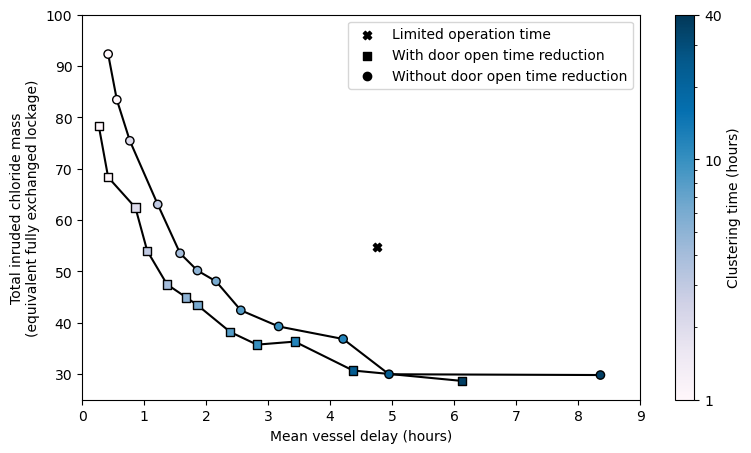

In [4]:
import matplotlib.colors as colors
from matplotlib.colors import Normalize, LogNorm

cmap = 'PuBu'
norm = colors.LogNorm(vmin=1, vmax=40)

clustering_times = trade_off_curve.index
fig,ax = plt.subplots(figsize=[9,5])
ax.set_xlabel('Mean vessel delay (hours)')
ax.set_ylabel('Total inruded chloride mass\n(equivalent fully exchanged lockage)')
ax.scatter([4.76],[54.75],facecolor='k',marker='X',label='Limited operation time')
ax.plot(trade_off_curve.vessel_delays[trade_off_curve.vessel_delays.notna()],
        trade_off_curve.intruded_mass[trade_off_curve.vessel_delays.notna()],
        color='k')
ax.plot(trade_off_curve.vessel_delays_r[trade_off_curve.vessel_delays_r.notna()],
        trade_off_curve.intruded_mass_r[trade_off_curve.vessel_delays_r.notna()],
        color='k')
im = ax.scatter(trade_off_curve.vessel_delays_r,
                trade_off_curve.intruded_mass_r,
                c=clustering_times, 
                edgecolor='k', 
                cmap=cmap, 
                norm=norm,
                marker='s',
                zorder=2,)
ax.scatter(0,0,marker='s',color='k',label='With door open time reduction')
im = ax.scatter(trade_off_curve.vessel_delays,
                trade_off_curve.intruded_mass,
                c=clustering_times, 
                edgecolor='k', 
                cmap=cmap, 
                norm=norm,
                zorder=2)
ax.scatter(0,0,marker='o',color='k',label='Without door open time reduction')
cbar = fig.colorbar(im)
cbar.set_label('Clustering time (hours)')
cbar.set_ticks([1,10,40])
cbar.set_ticklabels([1,10,40])
ax.set_xlim(0,9)
ax.set_ylim(25,100)
ax.legend();

np.float64(0.27)

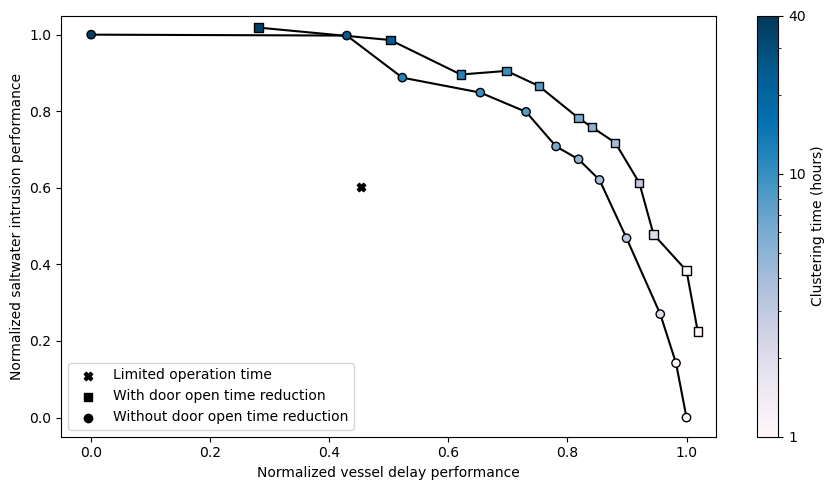

In [214]:
import matplotlib.colors as colors
from matplotlib.colors import Normalize, LogNorm

cmap = 'PuBu'
norm = colors.LogNorm(vmin=1, vmax=40)

trade_off_curve_norm = pd.DataFrame()
min_delays = trade_off_curve[['vessel_delays']].min().min()
max_delays = trade_off_curve[['vessel_delays']].max().max()

min_salt = trade_off_curve[['intruded_mass']].min().min()
max_salt = trade_off_curve[['intruded_mass']].max().max()

trade_off_curve_norm['vessel_delays'] =(trade_off_curve.vessel_delays-min_delays)/(max_delays-min_delays)
trade_off_curve_norm['vessel_delays_r'] =(trade_off_curve.vessel_delays_r-min_delays)/(max_delays-min_delays)
trade_off_curve_norm['intruded_mass'] =(trade_off_curve.intruded_mass-min_salt)/(max_salt-min_salt)
trade_off_curve_norm['intruded_mass_r'] =(trade_off_curve.intruded_mass_r-min_salt)/(max_salt-min_salt)

clustering_times = trade_off_curve.index
fig,ax = plt.subplots(figsize=[9,5])
ax.set_xlabel('Normalized vessel delay performance')
ax.set_ylabel('Normalized saltwater intrusion performance')
ax.scatter([1-(4.76-min_delays)/(max_delays-min_delays)],[1-(54.75-min_salt)/(max_salt-min_salt)],facecolor='k',marker='X',label='Limited operation time')
ax.plot(1-trade_off_curve_norm.vessel_delays[trade_off_curve_norm.vessel_delays.notna()],
        1-trade_off_curve_norm.intruded_mass[trade_off_curve_norm.vessel_delays.notna()],
        color='k')
ax.plot(1-trade_off_curve_norm.vessel_delays_r[trade_off_curve_norm.vessel_delays_r.notna()],
        1-trade_off_curve_norm.intruded_mass_r[trade_off_curve_norm.vessel_delays_r.notna()],
        color='k')
im = ax.scatter(1-trade_off_curve_norm.vessel_delays_r,
                1-trade_off_curve_norm.intruded_mass_r,
                c=clustering_times, 
                edgecolor='k', 
                cmap=cmap, 
                norm=norm,
                marker='s',
                zorder=2,)
ax.scatter(-1,-1,marker='s',color='k',label='With door open time reduction')
im = ax.scatter(1-trade_off_curve_norm.vessel_delays,
                1-trade_off_curve_norm.intruded_mass,
                c=clustering_times, 
                edgecolor='k', 
                cmap=cmap, 
                norm=norm,
                zorder=2)
ax.scatter(-1,-1,marker='o',color='k',label='Without door open time reduction')
cbar = fig.colorbar(im)
cbar.set_label('Clustering time (hours)')
cbar.set_ticks([1,10,40])
cbar.set_ticklabels([1,10,40])
ax.set_xlim(-.05,1.05)
ax.set_ylim(-.05,1.05)
ax.legend()
fig.tight_layout()
fig.savefig(output_path+'trade_off_curve.png',format='png',dpi=500);

In [207]:
optimum = []
for delay, mass in zip(trade_off_curve_norm.vessel_delays,trade_off_curve_norm.intruded_mass):
    optimum.append((1-delay)*(1-mass))
print(clustering_times[np.argmax(optimum)])

8.0


In [208]:
optimum_r = []
for delay, mass in zip(trade_off_curve_norm.vessel_delays_r,trade_off_curve_norm.intruded_mass_r):
    optimum_r.append((1-delay)*(1-mass))
print(clustering_times[np.argmax(optimum)])


8.0


(0.0, 10.0)

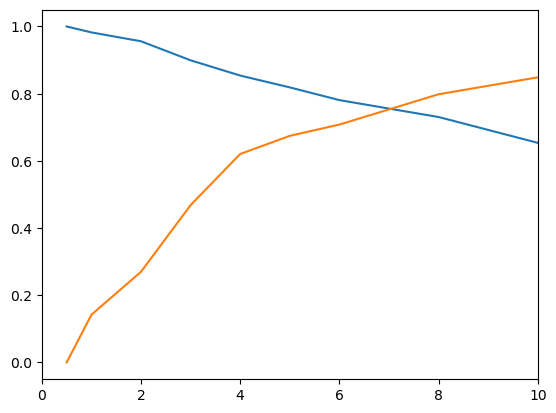

In [213]:
plt.plot(clustering_times,1-trade_off_curve_norm.vessel_delays)
plt.plot(clustering_times,1-trade_off_curve_norm.intruded_mass)
plt.xlim(0,10)

(0.0, 10.0)

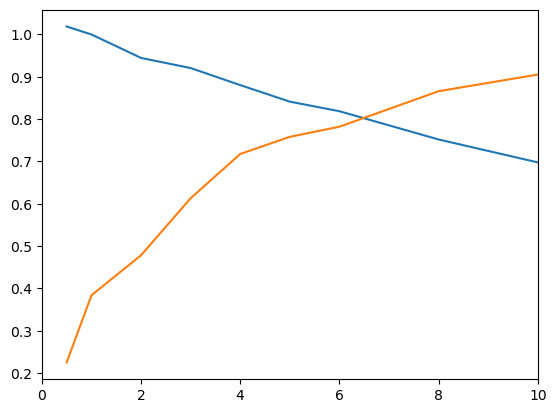

In [212]:
plt.plot(clustering_times,1-trade_off_curve_norm.vessel_delays_r)
plt.plot(clustering_times,1-trade_off_curve_norm.intruded_mass_r)
plt.xlim(0,10)

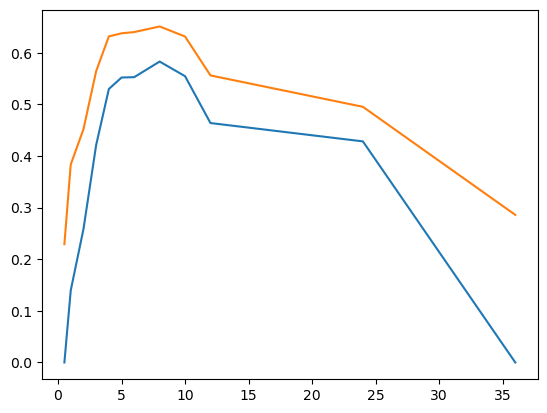

In [209]:
plt.plot(clustering_times,optimum)
plt.plot(clustering_times,optimum_r)